https://www.kaggle.com/code/sugghi/training-3rd-place-solution/notebook
ここのソリューションをBybitで実装してみる。

変更点：
    ・　通貨ペアーは取引の多いものを選ぶ（１４まで選ぶと１分足が作れない可能性があるため減らす）

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
import datetime

import pickle
import gc

from tqdm import tqdm

In [2]:
n_fold = 7
seed0 = 8586

In [3]:
# そのままコピー
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
import rbot

bb_btcusd = rbot.DummyBb()
bb_btcusd.market_type = "BTCUSD"
bb_btcusdt = rbot.DummyBb()
bb_btcusdt.market_type = "BTCUSDT"

bb_ethusd = rbot.DummyBb()
bb_ethusd.market_type = "ETHUSD"
bb_ethusdt = rbot.DummyBb()
bb_ethusdt.market_type = "ETHUSDT"

bb_xrpusdt = rbot.DummyBb()
bb_xrpusdt.market_type = "XRPUSDT"
bb_xrpusd = rbot.DummyBb()
bb_xrpusd.market_type = "XRPUSD"

bb_solusdt = rbot.DummyBb()
bb_solusdt.market_type = "SOLUSDT"


In [5]:
# 注意　１０GB レベルでDiskを消費します。
# 2回目は LOAD_NEWをFalseにするとダンプファイルからロードするので高速です。
LOAD_NEW = False
LOAD_DAYS = 100

if LOAD_NEW:
    bb_btcusd.log_load(LOAD_DAYS)
    bb_btcusd.dump()
    bb_btcusdt.log_load(LOAD_DAYS)
    bb_btcusdt.dump()
    bb_ethusd.log_load(LOAD_DAYS)
    bb_ethusd.dump()
    bb_ethusdt.log_load(LOAD_DAYS)
    bb_ethusdt.dump()
    bb_xrpusd.log_load(LOAD_DAYS)
    bb_xrpusd.dump()
    bb_xrpusdt.log_load(LOAD_DAYS)
    bb_xrpusdt.dump()
    bb_solusdt.log_load(LOAD_DAYS)
    bb_solusdt.dump()
else:
    bb_btcusd.restore()
    bb_btcusdt.restore()
    bb_ethusd.restore()
    bb_ethusdt.restore()
    bb_xrpusd.restore()
    bb_xrpusdt.restore()
    bb_solusdt.restore()


In [6]:
OFFSET_PERIOD = 15

# diff の方向はマイナスが正しい。
def log_return(series, periods=OFFSET_PERIOD):
    return np.log(series).diff(periods= - periods)

# Closeのログリターンを計算する（Closeでいいのかな？）
def make_df(dummy_bb, asset_id):
    df = rbot.array_to_df(dummy_bb.ohlcv(0, 0, 60))
    df['Target'] = log_return(df['close'], OFFSET_PERIOD)
    df['Asset_ID'] = asset_id
    
    return df

In [7]:
df_btcusd = make_df(bb_btcusd, 0)
df_btcusdt = make_df(bb_btcusdt, 1)
df_ethusd = make_df(bb_ethusd, 2)
df_ethusdt = make_df(bb_ethusdt, 3)
df_xrpusd = make_df(bb_xrpusd, 4)
df_xrpusdt = make_df(bb_xrpusdt, 5)
df_solusdt = make_df(bb_solusdt, 6)

df_train = pd.concat([df_btcusd, df_btcusdt, df_ethusd, df_ethusdt, df_xrpusd, df_xrpusdt, df_solusdt])
df_train = reduce_mem_usage(df_train)
df_train

Memory usage of dataframe is 61.43 MB
Memory usage after optimization is: 22.08 MB
Decreased by 64.1%


,open,high,low,close,volume,Target,Asset_ID
timestamp,,,,,,,
2022-03-27 00:00:00+00:00,44544.00000,44544.00000,44544.00000,44544.00000,122635.000000,-0.000191,0
2022-03-27 00:01:00+00:00,44544.00000,44544.00000,44512.00000,44512.00000,129101.000000,-0.000943,0
2022-03-27 00:02:00+00:00,44512.00000,44512.00000,44480.00000,44512.00000,407347.000000,-0.001122,0
2022-03-27 00:03:00+00:00,44512.00000,44512.00000,44512.00000,44512.00000,204417.000000,-0.001011,0
2022-03-27 00:04:00+00:00,44512.00000,44544.00000,44512.00000,44544.00000,487144.000000,0.000045,0
...,...,...,...,...,...,...,...
2022-07-04 23:55:00+00:00,36.84375,36.84375,36.78125,36.78125,1898.699951,NaN,6
2022-07-04 23:56:00+00:00,36.78125,36.81250,36.78125,36.81250,2975.899902,NaN,6
2022-07-04 23:57:00+00:00,36.81250,36.84375,36.78125,36.81250,3651.199951,NaN,6


In [8]:
df_train['timestamp'] = df_train.index.astype('int64')
df_train['Close'] = df_train["close"]
df_train = df_train.reset_index(drop=True)
df_train = reduce_mem_usage(df_train)
df_train


Memory usage of dataframe is 24.00 MB
Memory usage after optimization is: 24.00 MB
Decreased by 0.0%


,open,high,low,close,volume,Target,Asset_ID,timestamp,Close
0,44544.00000,44544.00000,44544.00000,44544.00000,122635.000000,-0.000191,0,1648339200000000000,44544.00000
1,44544.00000,44544.00000,44512.00000,44512.00000,129101.000000,-0.000943,0,1648339260000000000,44512.00000
2,44512.00000,44512.00000,44480.00000,44512.00000,407347.000000,-0.001122,0,1648339320000000000,44512.00000
3,44512.00000,44512.00000,44512.00000,44512.00000,204417.000000,-0.001011,0,1648339380000000000,44512.00000
4,44512.00000,44544.00000,44512.00000,44544.00000,487144.000000,0.000045,0,1648339440000000000,44544.00000
...,...,...,...,...,...,...,...,...,...
1006489,36.84375,36.84375,36.78125,36.78125,1898.699951,NaN,6,1656978900000000000,36.78125
1006490,36.78125,36.81250,36.78125,36.81250,2975.899902,NaN,6,1656978960000000000,36.81250
1006491,36.81250,36.84375,36.78125,36.81250,3651.199951,NaN,6,1656979020000000000,36.81250
1006492,36.81250,36.81250,36.65625,36.65625,3171.600098,NaN,6,1656979080000000000,36.65625


In [9]:
NUM_OF_ASSETS = 7

train_merged = pd.DataFrame()
train_merged[df_train.columns] = 0
for id in tqdm( range(NUM_OF_ASSETS) ):
    train_merged = train_merged.merge(df_train.loc[df_train["Asset_ID"] == id, ['timestamp', 'Close','Target']].copy(), on="timestamp", how='outer',suffixes=['', "_"+str(id)])
        
train_merged = train_merged.drop(df_train.columns.drop("timestamp"), axis=1)
train_merged = train_merged.sort_values('timestamp', ascending=True)
display(train_merged.head())


100%|██████████| 7/7 [00:00<00:00, 39.59it/s]


,timestamp,Close_0,Target_0,Close_1,Target_1,Close_2,Target_2,Close_3,Target_3,Close_4,Target_4,Close_5,Target_5,Close_6,Target_6
0,1648339200000000000,44544.0,-0.000191,44480.0,-0.000337,3146.0,0.001670,3144.0,0.001814,0.832520,0.001081,0.833008,0.000961,101.6875,-0.001573
1,1648339260000000000,44512.0,-0.000943,44480.0,-0.001158,3146.0,0.000875,3144.0,0.000971,0.832520,0.000360,0.833008,0.000600,101.6875,-0.002161
2,1648339320000000000,44512.0,-0.001122,44480.0,-0.001191,3144.0,0.000827,3142.0,0.000812,0.832520,0.000481,0.832520,0.000481,101.6875,-0.001670
3,1648339380000000000,44512.0,-0.001011,44480.0,-0.001203,3144.0,0.001081,3142.0,0.001130,0.832031,-0.000360,0.831543,-0.000841,101.7500,-0.001522
4,1648339440000000000,44544.0,0.000045,44512.0,-0.000022,3144.0,0.001815,3142.0,0.001863,0.832031,0.000000,0.832520,0.000000,101.7500,-0.001031


In [10]:
for id in range(NUM_OF_ASSETS):
    # print(id, train_merged[f'Close_{id}'].isnull().sum())   # Number of missing before forward fill
    train_merged[f'Close_{id}'] = train_merged[f'Close_{id}'].astype('object').fillna(method='ffill', limit=100)
    train_merged[f'Close_{id}'] = train_merged[f'Close_{id}'].astype('float64')


In [11]:
lags = [60,300,900]

def get_features(df, train=True):   
    if train == True:
        totimestamp = lambda s: np.int32(time.mktime(datetime.datetime.strptime(s, "%d/%m/%Y").timetuple()))
        valid_window = [totimestamp("12/03/2021")]
#         valid_window = [totimestamp("15/08/2021")]  #検証用
        df['train_flg'] = np.where(df['timestamp']>=valid_window[0], 0,1)

        supple_start_window = [totimestamp("22/09/2021")]

        #if use_supple_for_train:
        #    df['train_flg'] = np.where(df['timestamp']>=supple_start_window[0], 1 ,df['train_flg']  )
   
    for id in range(NUM_OF_ASSETS):    
        for lag in lags:
            df[f'log_close/mean_{lag}_id{id}'] = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.append(np.convolve( np.array(df[f'Close_{id}']), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1)  )
            df[f'log_return_{lag}_id{id}']     = np.log( np.array(df[f'Close_{id}']) /  np.roll(np.array(df[f'Close_{id}']), lag)  )
    for lag in lags:
        df[f'mean_close/mean_{lag}'] =  np.mean(df.iloc[:,df.columns.str.startswith(f'log_close/mean_{lag}_id')], axis=1)
        df[f'mean_log_returns_{lag}'] = np.mean(df.iloc[:,df.columns.str.startswith(f'log_return_{lag}_id')] ,    axis=1)
        for id in range(NUM_OF_ASSETS):
            df[f'log_close/mean_{lag}-mean_close/mean_{lag}_id{id}'] = np.array( df[f'log_close/mean_{lag}_id{id}']) - np.array( df[f'mean_close/mean_{lag}']  )
            df[f'log_return_{lag}-mean_log_returns_{lag}_id{id}']    = np.array( df[f'log_return_{lag}_id{id}'])     - np.array( df[f'mean_log_returns_{lag}'] )

    if train == True:
        for id in range(NUM_OF_ASSETS):
            df = df.drop([f'Close_{id}'], axis=1)
        oldest_use_window = [totimestamp("12/01/2019")]
        df = df[  df['timestamp'] >= oldest_use_window[0]   ]

    return df

In [12]:
feat = get_features(train_merged)
feat

,timestamp,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,train_flg,log_close/mean_60_id0,...,log_close/mean_900-mean_close/mean_900_id2,log_return_900-mean_log_returns_900_id2,log_close/mean_900-mean_close/mean_900_id3,log_return_900-mean_log_returns_900_id3,log_close/mean_900-mean_close/mean_900_id4,log_return_900-mean_log_returns_900_id4,log_close/mean_900-mean_close/mean_900_id5,log_return_900-mean_log_returns_900_id5,log_close/mean_900-mean_close/mean_900_id6,log_return_900-mean_log_returns_900_id6
0,1648339200000000000,-0.000191,-0.000337,0.001670,0.001814,0.001081,0.000961,-0.001573,0,10.704233,...,2.086736,0.105218,2.086100,0.103630,-6.150450,-0.023922,-6.149864,-0.024108,-1.345247,0.134220
1,1648339260000000000,-0.000943,-0.001158,0.000875,0.000971,0.000360,0.000600,-0.002161,0,10.703514,...,2.086838,0.105541,2.086202,0.103953,-6.150347,-0.024371,-6.149761,-0.024556,-1.345144,0.134543
2,1648339320000000000,-0.001122,-0.001191,0.000827,0.000812,0.000481,0.000481,-0.001670,0,10.703514,...,2.086468,0.105580,2.085832,0.103991,-6.150082,-0.024649,-6.150082,-0.025420,-1.344879,0.136163
3,1648339380000000000,-0.001011,-0.001203,0.001081,0.001130,-0.000360,-0.000841,-0.001522,0,10.703514,...,2.086632,0.105880,2.085995,0.103339,-6.150505,-0.024936,-6.151092,-0.026294,-1.344101,0.137077
4,1648339440000000000,0.000045,-0.000022,0.001815,0.001863,0.000000,0.000000,-0.001031,0,10.704233,...,2.086259,0.105642,2.085622,0.103101,-6.150878,-0.025173,-6.150291,-0.025358,-1.344474,0.135891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143993,1656978900000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.001056,...,0.006866,0.023811,0.006571,0.022777,-0.014834,-0.031662,-0.013496,-0.030974,0.029767,0.042347
143994,1656978960000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.001030,...,0.006939,0.023314,0.006643,0.023231,-0.015444,-0.032903,-0.013365,-0.029929,0.030665,0.042699
143995,1656979020000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000990,...,0.005862,0.022151,0.005568,0.022069,-0.013363,-0.030194,-0.013515,-0.030223,0.030434,0.042405
143996,1656979080000000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,-0.000634,...,0.006503,0.023745,0.006211,0.022711,-0.013898,-0.030789,-0.014047,-0.031587,0.028541,0.040533


In [13]:
# define features for LGBM
not_use_features_train = ['timestamp', 'train_flg']
for id in range(NUM_OF_ASSETS):
    not_use_features_train.append(f'Target_{id}')

features = feat.columns 
features = features.drop(not_use_features_train)
features = list(features)
# display(features)  
len(features)

90

In [14]:
#del train_merged
#del df_train
gc.collect()

72

In [15]:
# define the evaluation metric
def correlation(a, train_data):
    
    b = train_data.get_label()
    
    a = np.ravel(a)
    b = np.ravel(b)

    len_data = len(a)
    mean_a = np.sum(a) / len_data
    mean_b = np.sum(b) / len_data
    var_a = np.sum(np.square(a - mean_a)) / len_data
    var_b = np.sum(np.square(b - mean_b)) / len_data

    cov = np.sum((a * b))/len_data - mean_a*mean_b
    corr = cov / np.sqrt(var_a * var_b)

    return 'corr', corr, True

# For CV score calculation
def corr_score(pred, valid):
    len_data = len(pred)
    mean_pred = np.sum(pred) / len_data
    mean_valid = np.sum(valid) / len_data
    var_pred = np.sum(np.square(pred - mean_pred)) / len_data
    var_valid = np.sum(np.square(valid - mean_valid)) / len_data

    cov = np.sum((pred * valid))/len_data - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

# For CV score calculation
def wcorr_score(pred, valid, weight):
    len_data = len(pred)
    sum_w = np.sum(weight)
    mean_pred = np.sum(pred * weight) / sum_w
    mean_valid = np.sum(valid * weight) / sum_w
    var_pred = np.sum(weight * np.square(pred - mean_pred)) / sum_w
    var_valid = np.sum(weight * np.square(valid - mean_valid)) / sum_w

    cov = np.sum((pred * valid * weight)) / sum_w - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

In [16]:
# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
# (used in nyanp's Optiver solution)
def plot_importance(importances, features_names = features, PLOT_TOP_N = 20, figsize=(10, 10)):
    importance_df = pd.DataFrame(data=importances, columns=features)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

In [17]:
# from: https://www.kaggle.com/code/nrcjea001/lgbm-embargocv-weightedpearson-lagtarget/
def get_time_series_cross_val_splits(data, cv = n_fold, embargo = 3750):
    all_train_timestamps = data['timestamp'].unique()
    len_split = len(all_train_timestamps) // cv
    test_splits = [all_train_timestamps[i * len_split:(i + 1) * len_split] for i in range(cv)]
    # fix the last test split to have all the last timestamps, in case the number of timestamps wasn't divisible by cv
    rem = len(all_train_timestamps) - len_split*cv
    if rem>0:
        test_splits[-1] = np.append(test_splits[-1], all_train_timestamps[-rem:])

    train_splits = []
    for test_split in test_splits:
        test_split_max = int(np.max(test_split))
        test_split_min = int(np.min(test_split))
        # get all of the timestamps that aren't in the test split
        train_split_not_embargoed = [e for e in all_train_timestamps if not (test_split_min <= int(e) <= test_split_max)]
        # embargo the train split so we have no leakage. Note timestamps are expressed in seconds, so multiply by 60
        embargo_sec = 60*embargo
        train_split = [e for e in train_split_not_embargoed if
                       abs(int(e) - test_split_max) > embargo_sec and abs(int(e) - test_split_min) > embargo_sec]
        train_splits.append(train_split)

    # convenient way to iterate over train and test splits
    train_test_zip = zip(train_splits, test_splits)
    return train_test_zip

In [18]:
def get_Xy_and_model_for_asset(df_proc, asset_id):
    df_proc = df_proc.loc[  (df_proc[f'Target_{asset_id}'] == df_proc[f'Target_{asset_id}'])  ]
    #if not_use_overlap_to_train:
    #   df_proc = df_proc.loc[  (df_proc['train_flg'] == 1)  ]
    
# EmbargoCV
    train_test_zip = get_time_series_cross_val_splits(df_proc, cv = n_fold, embargo = 3750)
    print("entering time series cross validation loop")
    importances = []
    oof_pred = []
    oof_valid = []
    
    for split, train_test_split in enumerate(train_test_zip):
        gc.collect()
        
        print(f"doing split {split+1} out of {n_fold}")
        train_split, test_split = train_test_split
        train_split_index = df_proc['timestamp'].isin(train_split)
        test_split_index = df_proc['timestamp'].isin(test_split)
    
        train_dataset = lgb.Dataset(df_proc.loc[train_split_index, features],
                                    df_proc.loc[train_split_index, f'Target_{asset_id}'].values, 
                                    feature_name = features, 
                                   )
        val_dataset = lgb.Dataset(df_proc.loc[test_split_index, features], 
                                  df_proc.loc[test_split_index, f'Target_{asset_id}'].values, 
                                  feature_name = features, 
                                 )

        print(f"number of train data: {len(df_proc.loc[train_split_index])}")
        print(f"number of val data:   {len(df_proc.loc[test_split_index])}")

        model = lgb.train(params = params,
                          train_set = train_dataset, 
                          valid_sets=[train_dataset, val_dataset],
                          valid_names=['tr', 'vl'],
                          num_boost_round = 5000,
                          verbose_eval = 100,     
                          feval = correlation,
                         )
        importances.append(model.feature_importance(importance_type='gain'))
        
        file = f'trained_model_id{asset_id}_fold{split}.pkl'
        pickle.dump(model, open(file, 'wb'))
        print(f"Trained model was saved to 'trained_model_id{asset_id}_fold{split}.pkl'")
        print("")
            
        oof_pred += list(  model.predict(df_proc.loc[test_split_index, features])        )
        oof_valid += list(   df_proc.loc[test_split_index, f'Target_{asset_id}'].values    )
    
    
    plot_importance(np.array(importances),features, PLOT_TOP_N = 20, figsize=(10, 5))

    return oof_pred, oof_valid

In [19]:
# Weigthの計算が不明

df_asset_details = pd.DataFrame(data={
    'Asset_ID': [0, 1, 2, 3, 4, 5, 6], 
    'Weight': [1, 1, 1, 1, 1, 1, 1],
    "Asset_Name": ['BTCUSD', 'BTCUSDT', 'ETHUSD', 'ETHUSDT', 'XRPUSD', 'XRPUSDT', "SOLUSDT"],
    })
df_asset_details

,Asset_ID,Weight,Asset_Name
0,0,1,BTCUSD
1,1,1,BTCUSDT
2,2,1,ETHUSD
3,3,1,ETHUSDT
4,4,1,XRPUSD
5,5,1,XRPUSDT
6,6,1,SOLUSDT


In [20]:
params = {
    'early_stopping_rounds': 50,
    'objective': 'regression',
    'metric': 'rmse',
#     'metric': 'None',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'verbose': -1,
    'max_bin':600,
    'min_data_in_leaf':50,
    'learning_rate': 0.03,
    'subsample': 0.7,
    'subsample_freq': 1,
    'feature_fraction': 1,
    'lambda_l1': 0.5,
    'lambda_l2': 2,
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_fraction_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'extra_trees': True,
    'extra_seed': seed0,
    'zero_as_missing': True,
    "first_metric_only": True
    }

Training model for BTCUSD           (ID=0 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123414
number of val data:   20569


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	tr's rmse: 0.00428236	tr's corr: 0.16152	vl's rmse: 0.00262087	vl's corr: 0.0172991
Evaluated only: rmse
Trained model was saved to 'trained_model_id0_fold0.pkl'

doing split 2 out of 7
number of train data: 123414
number of val data:   20569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	tr's rmse: 0.00429754	tr's corr: 0.0732072	vl's rmse: 0.00249557	vl's corr: -0.0302633
Evaluated only: rmse
Trained model was saved to 'trained_model_id0_fold1.pkl'

doing split 3 out of 7
number of train data: 123414
number of val data:   20569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	tr's rmse: 0.00423463	tr's corr: 0.220761	vl's rmse: 0.00297625	vl's corr: 0.0174221
Evaluated only: rmse
Trained model was saved to 'trained_model_id0_fold2.pkl'

doing split 4 out of 7
number of train data: 1

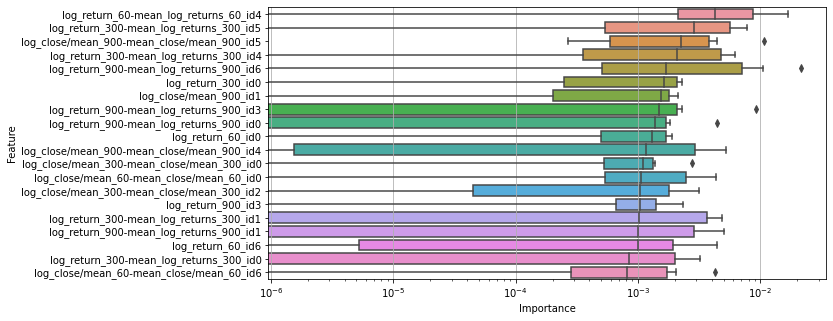

OOF corr score of BTCUSD (ID=0) is 0.00514. (Weight: 1.00000)


Training model for BTCUSDT          (ID=1 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123383
number of val data:   20563


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	tr's rmse: 0.00423626	tr's corr: 0.0806368	vl's rmse: 0.00260921	vl's corr: -0.0534548
Evaluated only: rmse
Trained model was saved to 'trained_model_id1_fold0.pkl'

doing split 2 out of 7
number of train data: 123383
number of val data:   20563
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	tr's rmse: 0.00424619	tr's corr: 0.14633	vl's rmse: 0.00249049	vl's corr: 0.0068289
Evaluated only: rmse
Trained model was saved to 'trained_model_id1_fold1.pkl'

doing split 3 out of 7
number of train data: 123383
number of val data:   20563
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	tr's rmse: 0.00417679	tr's corr: 0.229728	vl's rmse: 0.00297195	vl's corr: 0.0240594
Evaluated only: rmse
Trained model was saved to 'trained_model_id1_fold2.pkl'

doing split 4 out of 7
number of train data: 1

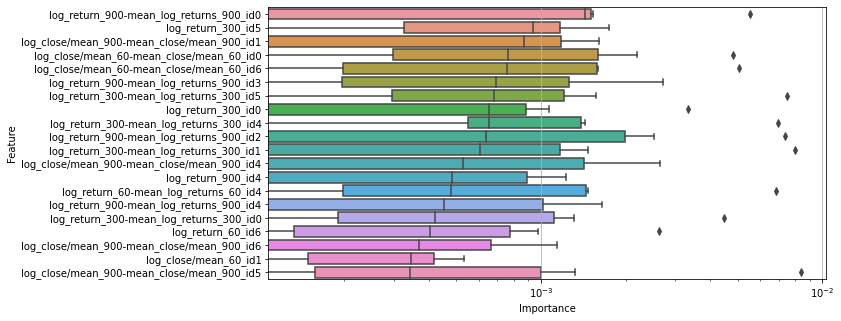

OOF corr score of BTCUSDT (ID=1) is -0.00769. (Weight: 1.00000)


Training model for ETHUSD           (ID=2 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123265
number of val data:   20544


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	tr's rmse: 0.00566764	tr's corr: 0.203756	vl's rmse: 0.00318179	vl's corr: 0.00505101
Evaluated only: rmse
Trained model was saved to 'trained_model_id2_fold0.pkl'

doing split 2 out of 7
number of train data: 123265
number of val data:   20544
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	tr's rmse: 0.00570348	tr's corr: 0.183654	vl's rmse: 0.00277327	vl's corr: 0.00851457
Evaluated only: rmse
Trained model was saved to 'trained_model_id2_fold1.pkl'

doing split 3 out of 7
number of train data: 123265
number of val data:   20544
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	tr's rmse: 0.00564105	tr's corr: 0.218833	vl's rmse: 0.00339635	vl's corr: 0.0148227
Evaluated only: rmse
Trained model was saved to 'trained_model_id2_fold2.pkl'

doing split 4 out of 7
number of train data: 1

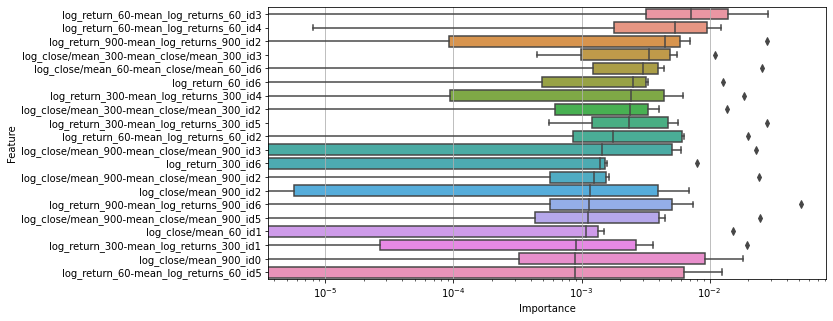

OOF corr score of ETHUSD (ID=2) is 0.01524. (Weight: 1.00000)


Training model for ETHUSDT          (ID=3 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123378
number of val data:   20563


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	tr's rmse: 0.00561793	tr's corr: 0.106633	vl's rmse: 0.00316272	vl's corr: 0.0200099
Evaluated only: rmse
Trained model was saved to 'trained_model_id3_fold0.pkl'

doing split 2 out of 7
number of train data: 123378
number of val data:   20563
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	tr's rmse: 0.00564738	tr's corr: 0.182685	vl's rmse: 0.00277528	vl's corr: 0.0300168
Evaluated only: rmse
Trained model was saved to 'trained_model_id3_fold1.pkl'

doing split 3 out of 7
number of train data: 123378
number of val data:   20563
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	tr's rmse: 0.00559159	tr's corr: 0.150051	vl's rmse: 0.00340992	vl's corr: 0.058127
Evaluated only: rmse
Trained model was saved to 'trained_model_id3_fold2.pkl'

doing split 4 out of 7
number of train data: 1233

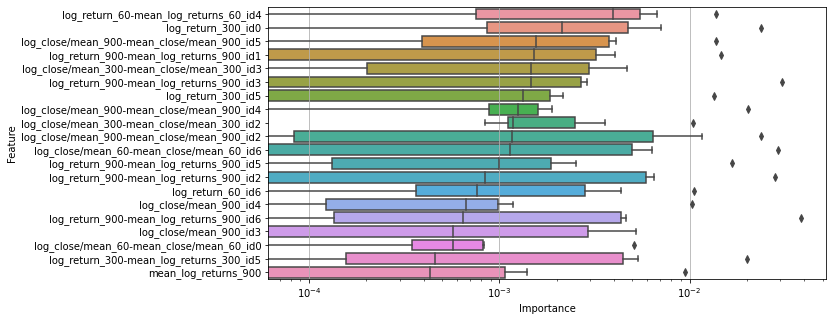

OOF corr score of ETHUSDT (ID=3) is 0.01634. (Weight: 1.00000)


Training model for XRPUSD           (ID=4 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 122989
number of val data:   20498


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	tr's rmse: 0.00552588	tr's corr: 0.302739	vl's rmse: 0.00353068	vl's corr: 0.042233
Evaluated only: rmse
Trained model was saved to 'trained_model_id4_fold0.pkl'

doing split 2 out of 7
number of train data: 122989
number of val data:   20498
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	tr's rmse: 0.00547854	tr's corr: 0.356879	vl's rmse: 0.00333102	vl's corr: 0.0296178
Evaluated only: rmse
Trained model was saved to 'trained_model_id4_fold1.pkl'

doing split 3 out of 7
number of train data: 122989
number of val data:   20498
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00525627	tr's corr: 0.404222	vl's rmse: 0.00399201	vl's corr: 0.163773
Early stopping, best iteration is:
[132]	tr's rmse: 0.00521447	tr's corr: 0.42105	vl's rmse: 0.00398875	vl's corr: 0.164864
Evaluated only: rmse
Trained model wa

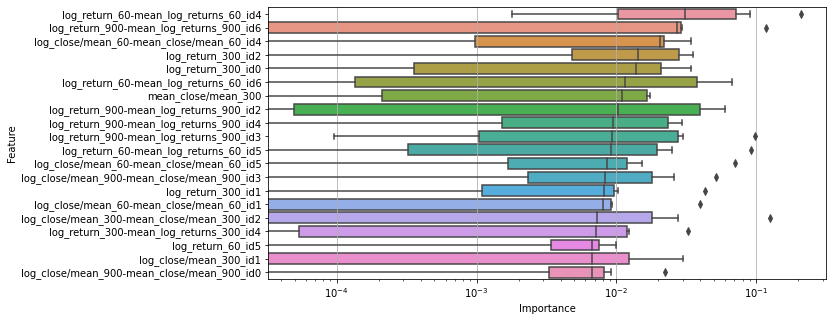

OOF corr score of XRPUSD (ID=4) is 0.06461. (Weight: 1.00000)


Training model for XRPUSDT          (ID=5 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 122841
number of val data:   20473


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	tr's rmse: 0.00547344	tr's corr: 0.349068	vl's rmse: 0.00358933	vl's corr: 0.0111047
Evaluated only: rmse
Trained model was saved to 'trained_model_id5_fold0.pkl'

doing split 2 out of 7
number of train data: 122841
number of val data:   20473
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.0053169	tr's corr: 0.406345	vl's rmse: 0.00337306	vl's corr: 0.0441301
Early stopping, best iteration is:
[73]	tr's rmse: 0.00536294	tr's corr: 0.392853	vl's rmse: 0.00337181	vl's corr: 0.0566694
Evaluated only: rmse
Trained model was saved to 'trained_model_id5_fold1.pkl'

doing split 3 out of 7
number of train data: 122841
number of val data:   20473
Training until validation scores don't improve for 50 rounds
[100]	tr's rmse: 0.00524099	tr's corr: 0.408069	vl's rmse: 0.00403104	vl's corr: 0.15351
Early stopping, best iteration is:
[126]	tr's rmse: 0.00520429	tr's co

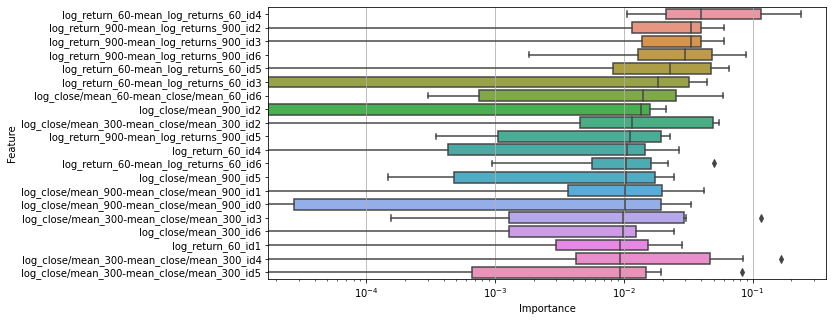

OOF corr score of XRPUSDT (ID=5) is 0.06311. (Weight: 1.00000)


Training model for SOLUSDT          (ID=6 )
entering time series cross validation loop
doing split 1 out of 7
number of train data: 123351
number of val data:   20558


/opt/homebrew/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	tr's rmse: 0.00814881	tr's corr: 0.311014	vl's rmse: 0.0060175	vl's corr: 0.0344582
Evaluated only: rmse
Trained model was saved to 'trained_model_id6_fold0.pkl'

doing split 2 out of 7
number of train data: 123351
number of val data:   20558
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	tr's rmse: 0.00831723	tr's corr: 0.292753	vl's rmse: 0.00448478	vl's corr: 0.0197775
Evaluated only: rmse
Trained model was saved to 'trained_model_id6_fold1.pkl'

doing split 3 out of 7
number of train data: 123351
number of val data:   20558
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	tr's rmse: 0.00832393	tr's corr: 0.236911	vl's rmse: 0.00475362	vl's corr: 0.0415427
Evaluated only: rmse
Trained model was saved to 'trained_model_id6_fold2.pkl'

doing split 4 out of 7
number of train data: 12

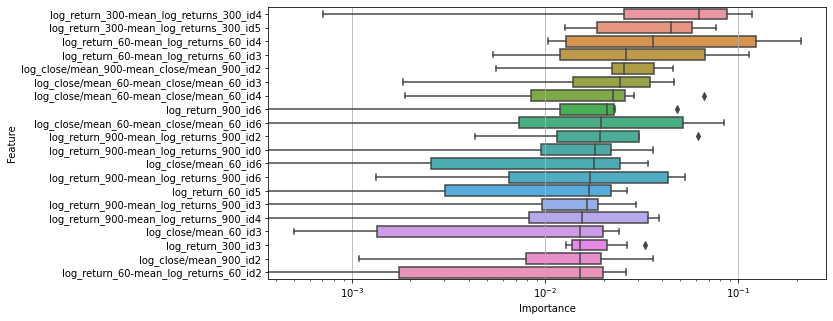

OOF corr score of SOLUSDT (ID=6) is 0.02585. (Weight: 1.00000)




In [21]:
oof = [ [] for id in range(NUM_OF_ASSETS)   ]

all_oof_pred = []
all_oof_valid = []
all_oof_weight = []

for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    
    oof_pred, oof_valid = get_Xy_and_model_for_asset(feat, asset_id)
    
    weight_temp = float( df_asset_details.loc[  df_asset_details['Asset_ID'] == asset_id  , 'Weight'   ]  )
    
    all_oof_pred += oof_pred
    all_oof_valid += oof_valid
    all_oof_weight += [weight_temp] * len(oof_pred)
    
    oof[asset_id] = corr_score(     np.array(oof_pred)   ,    np.array(oof_valid)    )
    
    print(f'OOF corr score of {asset_name} (ID={asset_id}) is {oof[asset_id]:.5f}. (Weight: {float(weight_temp):.5f})')
    print('')
    print('')

In [22]:
woof = 0
for id in range(NUM_OF_ASSETS):
    woof += oof[id] * float(  df_asset_details.loc[  df_asset_details['Asset_ID'] == id  , 'Weight'   ] )
woof = woof / df_asset_details['Weight'].sum()

print(f'OOF corr scores are;')
for oof_score in oof:
    print(f'      {oof_score:.5f}')
print(f'  simple average corr score: {np.mean(oof):.5f}.')
print(f'weighted average corr score: {woof:.5f}.')
print(f'')

all_oof_wcorr = wcorr_score(     np.array(all_oof_pred),    np.array(all_oof_valid),  np.array(all_oof_weight)   )
print(f'        weighted corr score: {all_oof_wcorr:.5f}.')

OOF corr scores are;
      0.00514
      -0.00769
      0.01524
      0.01634
      0.06461
      0.06311
      0.02585
  simple average corr score: 0.02609.
weighted average corr score: 0.02609.

        weighted corr score: 0.03636.
